In [2]:
import numpy as np
import xobjects as xo
import xtrack as xt
import xpart as xp
import json
import pandas as pd
from cpymad.madx import Madx
import NAFFlib
from math import modf
from matplotlib import pyplot as plt
from scipy.stats import linregress
import math

In [3]:
i_mo = 0
p0c = 7000e9
normal_emitt_x = 3e-6 #m*rad
normal_emitt_y = 3e-6 #m*rad
N_particles = 11 
N=1000
n_turns= 1



ctx_cpu = xo.ContextCpu()
#with open('hl_line.json', 'r') as fid:
with open('line_bb_for_tracking.json', 'r') as fid:
        loaded_dct = json.load(fid)
line = xt.Line.from_dict(loaded_dct)
particle_0 = xp.Particles(mass0=xp.PROTON_MASS_EV, q0=1, p0c=p0c, x=1e-3, y=1e-3)

line.vars['i_mo'] = i_mo
print(f"\n\nChanging Octupole Current, i_mo = {line.vars['i_mo']._get_value()}\n\n")
tracker_normal = xt.Tracker(_context=ctx_cpu, line=line)
ref = tracker_normal.find_closed_orbit(particle_ref = particle_0) 
print(f'\n\nref.x = {ref.x}, ref.y = {ref.y}, ref.zeta = {ref.zeta} \n\n')



tw_normal = tracker_normal.twiss(ref)
betx_at_ip3 = tw_normal['betx'][0]
bety_at_ip3 = tw_normal['bety'][0]
sigma_x = np.sqrt(betx_at_ip3*normal_emitt_x/(particle_0.gamma0*particle_0.beta0))
sigma_y = np.sqrt(bety_at_ip3*normal_emitt_y/(particle_0.gamma0*particle_0.beta0))

print(f'\n\nBeta values at ip3, betx = {betx_at_ip3}, bety = {bety_at_ip3}\n\n')
print(f'\n\nSigma values, sigma_x = {sigma_x}, sigma_y = {sigma_y}\n\n')

#----closed orbit particle----------
p0_normal = ref 
#----particles to track----------
particles_x = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
                                     x=[mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)])
particles_y = xp.build_particles(_context=ctx_cpu,particle_ref=p0_normal,
                                      y=[mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)])




ii = 0
sext_name = []
sext_str = []
for elem in line.element_dict :
    if(ii%5000 == 0):
        print('Iteration number ', ii, 'of', len(line.element_dict))
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole): 
        #if((line.element_dict[elem].order==2) and ( (ii!=425) and (ii != 373) and (ii!=471) and (ii!=523) and (ii!=569) and (ii!=619) ) and (True) ):
         #   line.element_dict[elem].knl[2]=0
        #if((line.element_dict[elem].order==2) and ( (ii==425) or (ii == 373) or (ii==471) or (ii==523) or (ii==569) or (ii==619) ) and (True) ):
            #print(ii,line.element_dict[elem].knl[2])
        if(line.element_dict[elem].order==3):
            sext_name.append(elem)
            sext_str.append(line.element_dict[elem].knl[2])
            #print(elem,line.element_dict[elem].knl[2],ii)
    ii+=1

sext_df = pd.DataFrame(list(zip(sext_name, sext_str)), columns = ['Sextupole Name', 'Sextupole Strength'])
tw_df = pd.DataFrame({'name':list(tw_normal['name']),'x':list(tw_normal['x']),'px':list(tw_normal['px']),'y':list(tw_normal['y']),'py':list(tw_normal['py']),'zeta':list(tw_normal['zeta']),'delta':list(tw_normal['delta']),'betx':list(tw_normal['betx']),'bety':list(tw_normal['bety']),'mux':list(tw_normal['mux']),'muy':list(tw_normal['muy'])})




#-----tracking x direction------------------


my_result_x = {}
for ii in ['x','px','y','py','zeta','delta']:
    my_result_x[ii] = []


for ii in range(N):
    tracker_normal.track(particles_x, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in ['x','px','y','py','zeta','delta']:
        my_result_x[jj].append(getattr(particles_x,jj).copy())       
        
        
for jj in ['x','px','y','py','zeta','delta']:
        my_result_x[jj] = np.array(my_result_x[jj])


#-----tracking y direction------------------

my_result_y = {}
for ii in ['x','px','y','py','zeta','delta']:
    my_result_y[ii] = []


for ii in range(N):
    tracker_normal.track(particles_y, num_turns=n_turns,turn_by_turn_monitor=False)
    for jj in ['x','px','y','py','zeta','delta']:
        my_result_y[jj].append(getattr(particles_y,jj).copy())       
        
        
for jj in ['x','px','y','py','zeta','delta']:
        my_result_y[jj] = np.array(my_result_y[jj])

qx_part_x = []
qy_part_x = []
qx_part_y = []
qy_part_y = []

for ii in range(N_particles):
    
    qx_part_x.append(NAFFlib.get_tune(my_result_x['x'][:,ii]))
    qy_part_x.append(NAFFlib.get_tune(my_result_x['y'][:,ii]))
    qx_part_y.append(NAFFlib.get_tune(my_result_y['x'][:,ii]))
    qy_part_y.append(NAFFlib.get_tune(my_result_y['y'][:,ii]))

x0 = np.array([mysigma*sigma_x[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 
y0 = np.array([mysigma*sigma_y[0] for mysigma in np.linspace(0.2,2.2,N_particles)]) 



Changing Octupole Current, i_mo = 0


generating ./ea96fce2f38640a2adc266a95417f71f.c
the current directory is '/afs/cern.ch/user/a/afornara/simulations/sim_stud/git_postprocessing'
running build_ext
building 'ea96fce2f38640a2adc266a95417f71f' extension
gcc -pthread -B /home/afornara/py/2022_03_18/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_03_18/miniconda/include -I/home/afornara/py/2022_03_18/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_03_18/miniconda/include -fPIC -I/home/afornara/py/2022_03_18/miniconda/include/python3.9 -c ea96fce2f38640a2adc266a95417f71f.c -o ./ea96fce2f38640a2adc266a95417f71f.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_03_18/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_03_18/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_03_18/miniconda/lib -L/home/afornara/py/2022_03_18/miniconda/lib -L/home/afornara/py/2022_

In [14]:
sext_str

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.024244612918852087,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.050368116311940464,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.024244612918852087,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 -0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 -0.050

m =  77930.73199232448 q =  0.3099999665717434


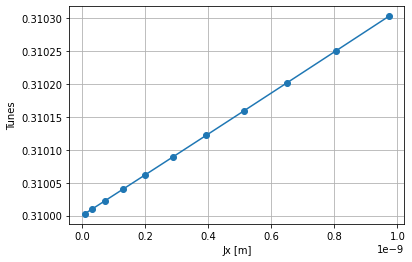

In [69]:
jx = np.zeros(N_particles)


for ii in range(N_particles):
    jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)



plt.plot(jx,qx_part_x,'-o');
plt.grid()
plt.ylabel('Tunes')
plt.xlabel('Jx [m]')


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[10]],[qx_part_x[0],qx_part_x[10]])
print('m = ',slope/4,'q = ',intercept)

m =  323179.1548385175 q =  0.3200000020437598


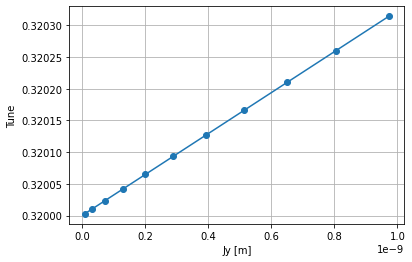

In [38]:
jy = np.zeros(N_particles)


for ii in range(N_particles):
    jy[ii] = y0[ii]*y0[ii]/(2*bety_at_ip3)

plt.plot(jy,qy_part_y,'-o');
plt.grid()
plt.ylabel('Tune')
plt.xlabel('Jy [m]')

slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[10]],[qy_part_y[0],qy_part_y[10]])
print('m = ',slope,'q = ',intercept)

m =  77951.75323900842 q =  0.3099999664239902


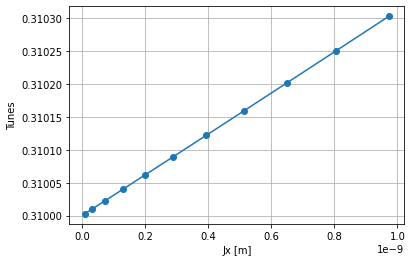

In [3]:
jx = np.zeros(N_particles)


for ii in range(N_particles):
    jx[ii] = x0[ii]*x0[ii]/(2*betx_at_ip3)



plt.plot(jx,qx_part_x,'-o');
plt.grid()
plt.ylabel('Tunes')
plt.xlabel('Jx [m]')


slope, intercept, r_value, p_value, std_err = linregress([jx[0],jx[10]],[qx_part_x[0],qx_part_x[10]])
print('m = ',slope/4,'q = ',intercept)

m =  334.1874377705573 q =  0.3200000027843082


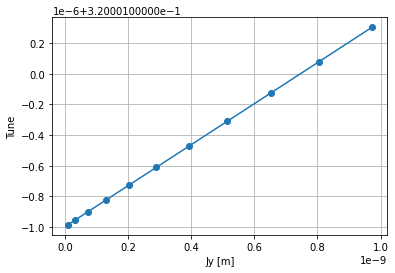

In [117]:
jy = np.zeros(N_particles)


for ii in range(N_particles):
    jy[ii] = y0[ii]*y0[ii]/(2*bety_at_ip3)

plt.plot(jy,qy_part_y,'-o');
plt.grid()
plt.ylabel('Tune')
plt.xlabel('Jy [m]')

slope, intercept, r_value, p_value, std_err = linregress([jy[0],jy[10]],[qy_part_y[0],qy_part_y[10]])
print('m = ',slope/4,'q = ',intercept)

In [4]:
tracker1 = xt.Tracker(_context=ctx_cpu, line=line)
tw = tracker_normal.twiss(ref)

generating ./7834c613cf46400c8d203e6b579f687e.c
the current directory is '/afs/cern.ch/user/a/afornara/simulations/git_dir'
running build_ext
building '7834c613cf46400c8d203e6b579f687e' extension
gcc -pthread -B /home/afornara/py/2022_17_03/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_17_03/miniconda/include -I/home/afornara/py/2022_17_03/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_17_03/miniconda/include -fPIC -I/home/afornara/py/2022_17_03/miniconda/include/python3.9 -c 7834c613cf46400c8d203e6b579f687e.c -o ./7834c613cf46400c8d203e6b579f687e.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_17_03/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_17_03/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_17_03/miniconda/lib -L/home/afornara/py/2022_17_03/miniconda/lib -L/home/afornara/py/2022_17_03/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_17_03/

In [6]:
print(tw_df)
print(sext_df)

               name    x   px    y   py  zeta  delta        betx        bety  \
0       lhcb1$start  0.0  0.0  0.0  0.0   0.0    0.0  121.563597  218.583776   
1               ip3  0.0  0.0  0.0  0.0   0.0    0.0  121.563597  218.583776   
2           drift_0  0.0  0.0  0.0  0.0   0.0    0.0  121.563597  218.583776   
3      mcbwv.4r3.b1  0.0  0.0  0.0  0.0   0.0    0.0   47.818854  345.899049   
4           drift_1  0.0  0.0  0.0  0.0   0.0    0.0   47.818854  345.899049   
...             ...  ...  ...  ...  ...   ...    ...         ...         ...   
23624   bpmw.4l3.b1  0.0  0.0  0.0  0.0   0.0    0.0  250.598562  118.349578   
23625   drift_11744  0.0  0.0  0.0  0.0   0.0    0.0  250.598562  118.349578   
23626  mcbwh.4l3.b1  0.0  0.0  0.0  0.0   0.0    0.0  225.459573  132.514130   
23627   drift_11745  0.0  0.0  0.0  0.0   0.0    0.0  225.459573  132.514130   
23628     lhcb1$end  0.0  0.0  0.0  0.0   0.0    0.0  121.564119  218.583776   

             mux        muy  
0       0

In [7]:

#tw_df = pd.DataFrame({'name':list(tw_normal['name']),'x':list(tw_normal['x']),'px':list(tw_normal['px']),'y':list(tw_normal['y']),'py':list(tw_normal['py']),'zeta':list(tw_normal['zeta']),'delta':list(tw_normal['delta']),'betx':list(tw_normal['betx']),'bety':list(tw_normal['bety']),'mux':list(tw_normal['mux']),'muy':list(tw_normal['muy'])})
jj = 0

l_name = []
l_str = []
l_betx = []
l_mux = []

for ii in range(len(tw_df['name'])):
    if(tw_df['name'][ii] == sext_df['Sextupole Name'][jj]):
        l_name.append(tw_df['name'][ii])
        l_str.append(sext_df['Sextupole Strength'][jj])
        l_betx.append(tw_df['betx'][ii])
        l_mux.append(tw_df['mux'][ii])
        jj += 1
        if(jj == 1628):
            break

second_order_df = pd.DataFrame(list(zip(l_name, l_str, l_betx, l_mux)), columns = ['Sextupole Name', 'Sextupole Strength', 'betx', 'mux'])

In [36]:
#with open('hl_line.json', 'r') as fid:
 #   loaded_dct = json.load(fid)
#line = xt.Line.from_dict(loaded_dct)
#line.vars['i_mo'] = 0
alpha_xx= 0.0
alpha_yy= 0.0
nu_x = tw_normal["qx"]
nu_y = tw_normal["qy"]
alpha_xx_list = []
l_components = []
l_comp_name = []
l_comp_str = []
l_comp_betx = []
l_comp_mux = []
l_comp_I1 = []
l_comp_I2 = []
l_comp_Sij = []
l_comp_betxij = []
#alpha_mat = np.zeros( (6, 6) )
#row = 0
#col = 0
for ii in range(len(second_order_df['Sextupole Name'])):
    if(ii%100 == 0):
        print('Iteration number ', ii, 'of', len(second_order_df['Sextupole Name']))
    count = 0
    for jj in range(len(second_order_df['Sextupole Name'])):
        psi_ij_mod_x=np.abs(2*np.pi*second_order_df['mux'][ii]-2*np.pi*second_order_df['mux'][jj])
        beta_i_beta_j_x = pow(second_order_df['betx'][ii],3/2)*pow(second_order_df['betx'][jj],3/2)
        S_i_S_j = second_order_df['Sextupole Strength'][ii]*second_order_df['Sextupole Strength'][jj]
        I1_x = (np.cos(3*(np.pi*nu_x-psi_ij_mod_x)))/(np.sin(3*np.pi*nu_x))
        I2_x = 3*(np.cos(np.pi*nu_x-psi_ij_mod_x)/(np.sin(np.pi*nu_x)))
        alpha_xx += beta_i_beta_j_x*(S_i_S_j)*((I1_x)+(I2_x))
        if((second_order_df['Sextupole Strength'][jj] != 0) and (second_order_df['Sextupole Strength'][ii] != 0) and (True)):
            #alpha_mat[row][col] = beta_i_beta_j_x*(S_i_S_j)*((I1_x)+(I2_x))
        #print(alpha_xx)
            alpha_xx_list.append(alpha_xx)
            l_components.append(beta_i_beta_j_x*(S_i_S_j)*((I1_x)+(I2_x)))
            l_comp_name.append(second_order_df['Sextupole Name'][ii])
            l_comp_str.append(second_order_df['Sextupole Strength'][jj])
            l_comp_betx.append(second_order_df['betx'][jj])
            l_comp_mux.append(second_order_df['mux'][jj])
            l_comp_I1.append(I1_x)
            l_comp_I2.append(I2_x)
            l_comp_Sij.append(S_i_S_j)
            l_comp_betxij.append(beta_i_beta_j_x)
            if False:
                print(f"ii= {ii}")
                print(f"jj= {jj}")
                print(f"\n\nSextupole jj name = {second_order_df['Sextupole Strength'][jj]}")
                print(f"Phase difference, psi_ij_mod_x = {psi_ij_mod_x}")
                print(f"Betx of jj element, betx[jj] = {second_order_df['betx'][jj]}")
                print(f"Sextupole strength product = {S_i_S_j}")
                print(f"I1_x = {I1_x}")
                print(f"I2_x = {I2_x}")
                print(f"alpha_xx = {alpha_xx}")
                alpha_xx_tot = -alpha_xx/(16*np.pi)
                print(f"alpha_xx_tot = {alpha_xx_tot}\n\n")
                print('---------------------------------------------------------------------')
alpha_xx_tot = -alpha_xx/(16*np.pi)    
print(alpha_xx_tot)
#alpha_xx_list
components_df = pd.DataFrame(list(zip(l_components,l_comp_I1,l_comp_I2,l_comp_Sij,l_comp_betxij,l_comp_name, l_comp_str, l_comp_betx, l_comp_mux)), columns = ['Component','I1_x','I2_x','Sij','betxij','Sextupole Name', 'Sextupole Strength', 'betx', 'mux'])

Iteration number  0 of 1628
Iteration number  100 of 1628
Iteration number  200 of 1628
Iteration number  300 of 1628
Iteration number  400 of 1628
Iteration number  500 of 1628
Iteration number  600 of 1628
Iteration number  700 of 1628
Iteration number  800 of 1628
Iteration number  900 of 1628
Iteration number  1000 of 1628
Iteration number  1100 of 1628
Iteration number  1200 of 1628
Iteration number  1300 of 1628
Iteration number  1400 of 1628
Iteration number  1500 of 1628
Iteration number  1600 of 1628
-184.53854265133944


[-7884.823754113531,
 -12764.503886088542,
 1809.2057361832194,
 3126.0418846487173,
 12488.699759358886,
 15870.501300260334,
 10990.821168285323,
 10629.4416487991,
 6343.022112728529,
 6681.601995276091,
 8422.197798251505,
 8731.045340795039,
 23304.7549630668,
 19018.33542699623,
 11219.796502370385,
 7140.806347044287,
 13126.720304414375,
 13792.982837944039,
 15109.818986409537,
 15448.398868957098,
 11369.408713630999,
 11162.21957438379,
 7479.299428877182,
 7644.698700815114,
 17007.356575525282,
 18747.952378500697,
 24733.866335870785,
 21050.94619036418,
 13191.044987884354,
 9077.554028477,
 12459.355569378447,
 12768.203111921981,
 13434.465645451644,
 13599.864917389576,
 9486.373957982221,
 9275.918878361836]

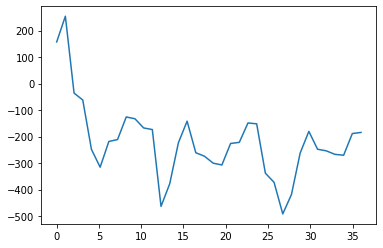

In [33]:
alpha_xx_tot_list = []
for ii in range(len(alpha_xx_list)):
    alpha_xx_tot_list.append(-alpha_xx_list[ii]/(16*np.pi))

x = np.linspace(0, len(alpha_xx_tot_list),len(alpha_xx_tot_list))
plt.plot(x,alpha_xx_tot_list)
#plt.xlim(18840,18860)
#plt.ylim(-315,315)
if False:
    for ii in range(len(alpha_xx_list)):
        if(alpha_xx_list[ii]!=0):
            print(ii,alpha_xx_tot_list[ii])

len(alpha_xx_tot_list)
alpha_xx_list

In [37]:
components_df

,Component,I1_x,I2_x,Sij,betxij,Sextupole Name,Sextupole Strength,betx,mux
0,-7884.823754,-4.473831,2.038792,0.000588,5.508781e+06,ms.11r3.b1,0.024245,176.611301,1.007487
1,-4879.680132,3.509874,3.529266,-0.001221,5.676763e+05,ms.11r3.b1,-0.050368,38.819390,1.125417
2,14573.709622,1.232862,3.292710,0.000588,5.478556e+06,ms.11r3.b1,0.024245,175.964709,1.231375
3,1316.836148,-3.573702,1.064947,-0.001221,4.298357e+05,ms.11r3.b1,-0.050368,32.249020,1.365061
4,9362.657875,4.446875,-1.550861,0.000588,5.500067e+06,ms.11r3.b1,0.024245,176.425025,1.482801
5,3381.801541,-2.920382,-3.472232,-0.001221,4.332103e+05,ms.11r3.b1,-0.050368,32.417585,1.615795
6,-4879.680132,3.509874,3.529266,-0.001221,5.676763e+05,ms.12r3.b1,0.024245,176.611301,1.007487
7,-361.379519,-4.473831,2.038792,0.002537,5.849869e+04,ms.12r3.b1,-0.050368,38.819390,1.125417
8,-4286.419536,2.761080,3.456369,-0.001221,5.645617e+05,ms.12r3.b1,0.024245,175.964709,1.231375
9,338.579883,-0.113203,3.126222,0.002537,4.429430e+04,ms.12r3.b1,-0.050368,32.249020,1.365061


In [11]:
zeors_array = np.zeros( (6, 6) )
print(zeors_array)

[[0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0.]]


In [35]:
9275.918878361836/(64*np.pi)

46.13463566283486

In [ ]:
with open('hl_line.json', 'r') as fid:
    loaded_dct = json.load(fid)
line = xt.Line.from_dict(loaded_dct)
line.vars['i_mo'] = 0
alpha_xx= 0.0
alpha_yy= 0.0
nu_x = tw["qx"]
nu_y = tw["qy"]
ii = 0
for elem in line.element_dict :
    if(ii%5000 == 0):
        print('Iteration number ', ii, 'of', len(line.element_dict))
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole): 
        if(line.element_dict[elem].order==2):
            jj = 0  
            for elem2 in line.element_dict :
                if isinstance(line.element_dict[elem2],xt.beam_elements.elements.Multipole): 
                    if((line.element_dict[elem2].order==2) and (not math.isclose(line.element_dict[elem].knl[2], 0)) 
                       and (not math.isclose(line.element_dict[elem2].knl[2], 0))):
                        
                        psi_ij_mod_x=np.abs(2*np.pi*tw['mux'][ii]-2*np.pi*tw['mux'][jj])
      
                        beta_i_beta_j_x = pow(tw['betx'][ii],3/2)*pow(tw['betx'][jj],3/2)
        
                        S_i_S_j = line.element_dict[elem].knl[2]*line.element_dict[elem2].knl[2]
                
                        I1_x = (np.cos(3*(np.pi*nu_x-psi_ij_mod_x)))/(np.sin(3*np.pi*nu_x))
                    
                        I2_x = 3*(np.cos(np.pi*nu_x-psi_ij_mod_x)/(np.sin(np.pi*nu_x)))

                        alpha_xx += beta_i_beta_j_x*(S_i_S_j)*((I1_x)+(I2_x))
                        
                        
                        if((jj==373)and(True)):
                           
                            print('psi_ij_mod_x = ',psi_ij_mod_x,'beta_i_beta_j_x = ',beta_i_beta_j_x,'S_i_S_j =',S_i_S_j,'I1_x = ',I1_x, 'I2_x = ', I2_x)
                            #print('psi_ij_mod_y = ',psi_ij_mod_y,'beta_i_beta_j_y = ',beta_i_beta_j_y,'S_i_S_j =',S_i_S_j,'I1_y = ',I1_y, 'I2_y = ', I2_y)
                            alpha_xx_tot = -alpha_xx/(16*np.pi)
                            alpha_yy_tot = -alpha_yy/(16*np.pi)
                            print('elem is',elem2,'and tw[name][elem]=',tw['name'][jj],'with beta=',tw['betx'][jj], 'with knl=',
                                  line.element_dict[elem2].knl[2], 'ii =', ii, 'jj = ', jj)
                            print('alpha_xx_tot = ',alpha_xx_tot)
                            #print('alpha_yy_tot = ',alpha_yy_tot)
                            print('---------------------------------------------------------------------')
                        
                jj+=1
            
    ii+=1
    
alpha_xx_tot = -alpha_xx/(16*np.pi)
print(alpha_xx_tot)

In [119]:
with open('hl_line.json', 'r') as fid:
    loaded_dct = json.load(fid)
line = xt.Line.from_dict(loaded_dct)
line.vars['i_mo'] = 0
alpha_xx= 0.0
alpha_yy= 0.0
nu_x = tw["qx"]
nu_y = tw["qy"]
ii = 0
for elem in line.element_dict :
    if(ii%5000 == 0):
        print('Iteration number ', ii, 'of', len(line.element_dict))
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole): 
        if(line.element_dict[elem].order==2):
            jj = 0  
            for elem2 in line.element_dict :
                if isinstance(line.element_dict[elem2],xt.beam_elements.elements.Multipole): 
                    if((line.element_dict[elem2].order==2) and (not math.isclose(line.element_dict[elem].knl[2], 0)) 
                       and (not math.isclose(line.element_dict[elem2].knl[2], 0))):
                        
                        psi_ij_mod_x=np.abs(2*np.pi*tw['mux'][ii]-2*np.pi*tw['mux'][jj])
                        
                        #psi_ij_mod_y=np.abs(2*np.pi*tw['muy'][jj]-2*np.pi*tw['muy'][ii])
                        
                        beta_i_beta_j_x = pow(tw['betx'][ii],3/2)*pow(tw['betx'][jj],3/2)
                        
                        #beta_i_beta_j_y = pow(tw['bety'][ii],3/2)*pow(tw['bety'][jj],3/2)
               
                        S_i_S_j = line.element_dict[elem].knl[2]*line.element_dict[elem2].knl[2]
                
                        I1_x = (np.cos(3*(np.pi*nu_x-psi_ij_mod_x)))/(np.sin(3*np.pi*nu_x))
                    
                        I2_x = 3*(np.cos(np.pi*nu_x-psi_ij_mod_x)/(np.sin(np.pi*nu_x)))
                        
                        #I1_y = (np.cos(3*(np.pi*nu_y-psi_ij_mod_y)))/(np.sin(3*np.pi*nu_y))
                    
                        #I2_y = 3*(np.cos(np.pi*nu_y-psi_ij_mod_y)/(np.sin(np.pi*nu_y)))
                        
                        alpha_xx += beta_i_beta_j_x*(S_i_S_j)*((I1_x)+(I2_x))
                        
                        #alpha_yy += beta_i_beta_j_y*(S_i_S_j)*((I1_y)+(I2_y))
                        
                        if((jj==373)and(True)):
                           
                            print('psi_ij_mod_x = ',psi_ij_mod_x,'beta_i_beta_j_x = ',beta_i_beta_j_x,'S_i_S_j =',S_i_S_j,'I1_x = ',I1_x, 'I2_x = ', I2_x)
                            #print('psi_ij_mod_y = ',psi_ij_mod_y,'beta_i_beta_j_y = ',beta_i_beta_j_y,'S_i_S_j =',S_i_S_j,'I1_y = ',I1_y, 'I2_y = ', I2_y)
                            alpha_xx_tot = -alpha_xx/(16*np.pi)
                            alpha_yy_tot = -alpha_yy/(16*np.pi)
                            print('elem is',elem2,'and tw[name][elem]=',tw['name'][jj],'with beta=',tw['betx'][jj], 'with knl=',
                                  line.element_dict[elem2].knl[2], 'ii =', ii, 'jj = ', jj)
                            print('alpha_xx_tot = ',alpha_xx_tot)
                            #print('alpha_yy_tot = ',alpha_yy_tot)
                            print('---------------------------------------------------------------------')
                        
                jj+=1
            
    ii+=1
    
alpha_xx_tot = -alpha_xx/(16*np.pi)
print(alpha_xx_tot)

generating ./56bfe4d2c34f4cd7bb515eeb301e8886.c
the current directory is '/afs/cern.ch/user/a/afornara/simulations/git_dir'
running build_ext
building '56bfe4d2c34f4cd7bb515eeb301e8886' extension
gcc -pthread -B /home/afornara/py/2022_17_03/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_17_03/miniconda/include -I/home/afornara/py/2022_17_03/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_17_03/miniconda/include -fPIC -I/home/afornara/py/2022_17_03/miniconda/include/python3.9 -c 56bfe4d2c34f4cd7bb515eeb301e8886.c -o ./56bfe4d2c34f4cd7bb515eeb301e8886.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_17_03/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_17_03/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_17_03/miniconda/lib -L/home/afornara/py/2022_17_03/miniconda/lib -L/home/afornara/py/2022_17_03/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_17_03/

KeyboardInterrupt: 

In [116]:
195971.52679533127


873.7304802066317/2

436.86524010331584

In [78]:
tracker1 = xt.Tracker(_context=ctx_cpu, line=line)
tw = tracker_normal.twiss(ref)


with open('hl_line.json', 'r') as fid:
    loaded_dct = json.load(fid)
line = xt.Line.from_dict(loaded_dct)
line.vars['i_mo'] = 0
alpha_xx= 0.0
nu_x = tw["qx"]% 1
nu_y = tw["qy"]% 1
ii = 0
for elem in line.element_dict :
    if(ii%5000 == 0):
        print('Iteration number ', ii, 'of', len(line.element_dict))
    if isinstance(line.element_dict[elem],xt.beam_elements.elements.Multipole): 
        if(line.element_dict[elem].order==2):
            jj = 0  
            for elem2 in line.element_dict :
                if isinstance(line.element_dict[elem2],xt.beam_elements.elements.Multipole): 
                    if((line.element_dict[elem2].order==2) and (not math.isclose(line.element_dict[elem].knl[2], 0)) 
                       and (not math.isclose(line.element_dict[elem2].knl[2], 0))):
                        
                        psi_ij_mod_x=np.abs(2*np.pi*tw['mux'][jj]-2*np.pi*tw['mux'][ii])
                        
                        beta_i_beta_j = pow(tw['betx'][ii],3/2)*pow(tw['betx'][jj],3/2)
               
                        S_i_S_j = line.element_dict[elem].knl[2]*line.element_dict[elem2].knl[2]
                
                        I1 = (np.cos(3*(np.pi*nu_x-psi_ij_mod_x)))/(np.sin(3*np.pi*nu_x))
                    
                        I2 = 3*(np.cos(np.pi*nu_x-psi_ij_mod_x)/(np.sin(np.pi*nu_x)))
                        
                        alpha_xx = beta_i_beta_j*(S_i_S_j)*((3/(np.tan(nu_x)))+(1/np.tan(3*nu_x)))
                        alpha_xx = -alpha_xx/(64*np.pi)
                        if(jj==373):
                            print('psi_ij_mod_x = ',psi_ij_mod_x,'beta_i_beta_j = ',beta_i_beta_j,'S_i_S_j',S_i_S_j,'I1 ',I1, 'I2', I2)
                            print('elem is',elem,'elem2 is',elem2,'and tw[name][elem]=',tw['name'][jj],'with beta=',tw['betx'][jj], 'with knl=',
                                  line.element_dict[elem2].knl[2], 'ii =', ii, 'jj = ', jj)
                            print('alpha_xx = ',alpha_xx)
                            print('---------------------------------------------------------------------')
                jj+=1
            
    ii+=1
    
alpha_xx_tot = -alpha_xx/(16*np.pi)
print(alpha_xx_tot)

generating ./65d64294e0584b11b65636e01bcb8385.c
the current directory is '/afs/cern.ch/user/a/afornara/simulations/git_dir'
running build_ext
building '65d64294e0584b11b65636e01bcb8385' extension
gcc -pthread -B /home/afornara/py/2022_17_03/miniconda/compiler_compat -Wno-unused-result -Wsign-compare -DNDEBUG -O2 -Wall -fPIC -O2 -isystem /home/afornara/py/2022_17_03/miniconda/include -I/home/afornara/py/2022_17_03/miniconda/include -fPIC -O2 -isystem /home/afornara/py/2022_17_03/miniconda/include -fPIC -I/home/afornara/py/2022_17_03/miniconda/include/python3.9 -c 65d64294e0584b11b65636e01bcb8385.c -o ./65d64294e0584b11b65636e01bcb8385.o -std=c99 -O3 -Wno-unused-function
gcc -pthread -B /home/afornara/py/2022_17_03/miniconda/compiler_compat -shared -Wl,-rpath,/home/afornara/py/2022_17_03/miniconda/lib -Wl,-rpath-link,/home/afornara/py/2022_17_03/miniconda/lib -L/home/afornara/py/2022_17_03/miniconda/lib -L/home/afornara/py/2022_17_03/miniconda/lib -Wl,-rpath,/home/afornara/py/2022_17_03/

KeyboardInterrupt: 

2.8284271247461903

In [ ]:
206586878.711114